In [8]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [9]:
fp = open("./lightcurves/tesslc_78452879.pkl","rb")
data = pickle.load(fp)
fp.close()

In [10]:
def cutLightCurve(times, lc, t0, t1): 
    ## Cuts a light curve to be between t0 and t1
    ##Assumption t0 < t1
    newTimes = []
    newLc = []
    i = 0
    while i < len(times):
        if times[i] > t0 and times[i] < t1:
            newTimes.append(times[i])    
            newLc.append(lc[i])
        i += 1
                
    return newTimes,newLc

In [11]:
def fillLightCurve(times, lc):
    ## Fills times gaps with median light curve value
    ##Assumption: Filling gaps with the median flux value will not make the light curve super wierd
    med = np.median(lc)
    dif = []
    for i in range(len(times) -1):
        dif.append(times[i+1]-times[i])
    
    print(max(dif), min(dif))
    newTimes = []
    newLc = []
    i = 0
    while i < len(times):
        if times[i] - times[i-1] > 1.2*min(dif):
            times = np.insert(times, i, times[i-1]+min(dif))
            lc = np.insert(lc,i,med)
        newTimes.append(times[i])    
        newLc.append(lc[i])
        i += 1
        
    return newTimes, newLc

In [12]:
def ebtExtendLC(LC, overlapTimes, times): 
    ##Extends a light curve from Eight Bit Transit by adding full flux to the ends for the desired length
    ##Assumption: Maximum flux value is 1
    ##Assumption: Light curve is at maximum value at the start and end
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    for i in range(len(times)):##Iterate over the desired time array
        if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
            if overlapIndex < len(overlapTimes) - 1:##Only do this to the end of the ebt light curve
                overlapIndex += 1
                extendedLC[i] = LC[overlapIndex]
        
    
    return extendedLC, times

In [13]:
def ebtSumLightCurves(trueLC, genLC): 
    ##Sums a true light curve and a generated lightcurve
    ##Assumptions: 1 is the maximal value for both light curves
    ##Assumption: The sum of both light curves is greater than one at every point, this can be satisfied by using a non-variable true light curve and leaving >1% as the minimum in the generated curve
    if len(trueLC) - len(genLC) != 0:
        raise Exception("Light Curves must be the same size: " + str(len(trueLC))+ "," + str(len(genLC)))
    sumLC = trueLC + genLC - 1
    ##Generated Light curve has no noise, subtracting 1 from this light curve gives reduction due to transit
    ##Preserves noise in original light curve (average would half it)
    ##Assumes min value in both light curves >0.5, anything violating this assumption is grounds for further investigation in itself 
    return sumLC

In [14]:
def duplicateLightCurve(lc,times,t0,t1):
    ##Takes a periodic light curve and extends it while replicating the behavior
    ##Assumptions: The input light curve is some integer multiple of whole periods, the first and last values are the same or similar
    diff = []
    for i in range(len(times) - 1):
        diff.append(times[i+1]-times[i])
        
    print(max(diff),min(diff))
    i = 1
    while times[0] > t0:
        times = np.insert(times,0,times[0]-min(diff))
        lc = np.insert(lc,0,lc[-i])
        i += 1
    i -= 1
    while times[-1] < t1:
        times = np.insert(times, len(times), times[-1]+min(diff))
        lc = np.insert(lc,len(lc),lc[i])
        i += 1
    return lc, times

In [15]:
def cleanTimes(lc, times, newTimes):
    ##Removes all datapoints from lc and times when an element in the times array does not have a corresponding element in the newTimes array
    ##Removes the filling done by cutTimes, use these two functions in conjunction
    ##Assumption: times array is larger than newTimes
    ##Assumption: times[0] = newTimes[0]
    ##Assumption: The difference between the first two elements in the times array is representative of a typical difference
    i = 0
    diff = times[1] - times[0]
    while i < len(newTimes) and i < len(times):
        if abs(newTimes[i] - times[i]) > 0.9*diff:
            times = np.delete(times, i)
            lc = np.delete(lc,i)
        else:
            i += 1
    return lc, newTimes

1.4583311922563098 0.020833063083500747


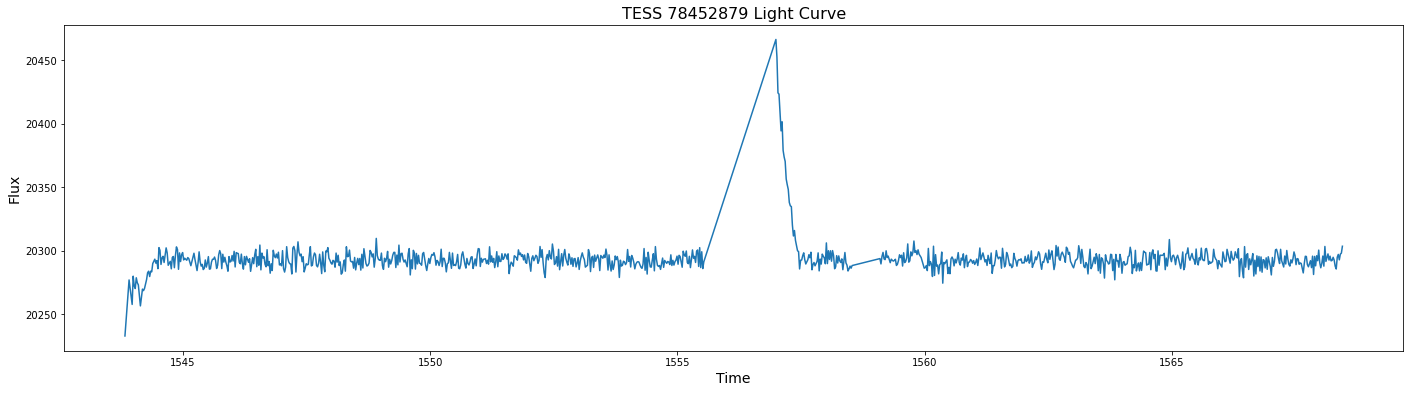

In [16]:
q = data[11]==0 #Importing data from the pickle file
times = data[6][q]
lc = data[8][q]
'''
medLc = np.median(lc) 
for i in range(len(lc)): ##Replacing low quality data with the median, it is important that the time array has regular spacing
    if q[i] != 0:
        lc[i] = medLc
'''
        
cutTimes, cutLc = fillLightCurve(times, lc) ##Fill Gaps
midTime = np.percentile(cutTimes,66) ##Set the 0 point at 3/4. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
##Tess light curves seem to have a 2 day gap near the center
cutTimes = cutTimes - midTime


fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting
ax.plot(times,lc)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"TESS 78452879 Light Curve",fontsize=16)
plt.show()

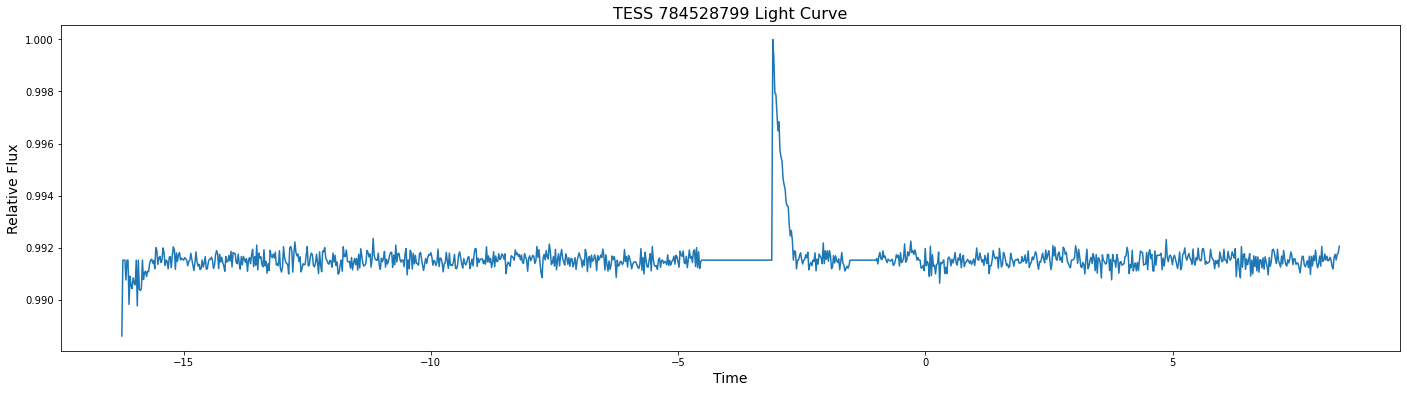

In [17]:
maxlc = max(cutLc)##Normalize Light Curve
normLc = cutLc/maxlc

fig, ax = plt.subplots(1,1,figsize=(24,6))
ax.plot(cutTimes,normLc)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative Flux",fontsize=14)
plt.title(r"TESS 784528799 Light Curve",fontsize=16)
plt.show()

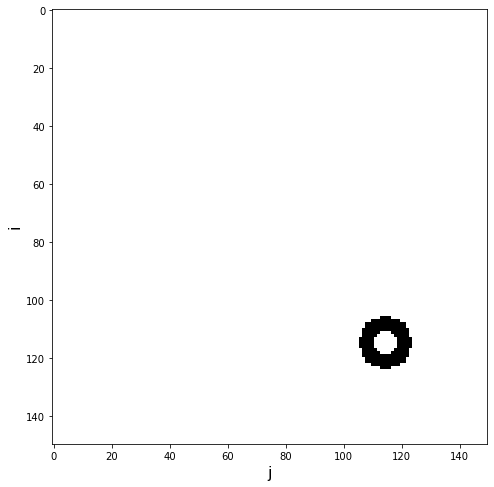

In [47]:
#times = np.linspace(-10.0,10.0,500) ##Create Eight Bit Transit Object

planetGrid = np.zeros((150,150))
planetGrid[106:124,113:117] = 1
planetGrid[113:117,106:124] = 1
planetGrid[107:123,110:120] = 1
planetGrid[110:120,107:123] = 1
planetGrid[108:122,108:122] = 1
planetGrid[109:121,109:121] = 1
planetGrid[112:118,112:118] = 0
planetGrid[111:119,113:117] = 0
planetGrid[113:117,111:119] = 0

planet = TransitingImage(opacitymat = planetGrid, v = 1, t_ref = 0, t_arr = cutTimes)

planet.plot_grid()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


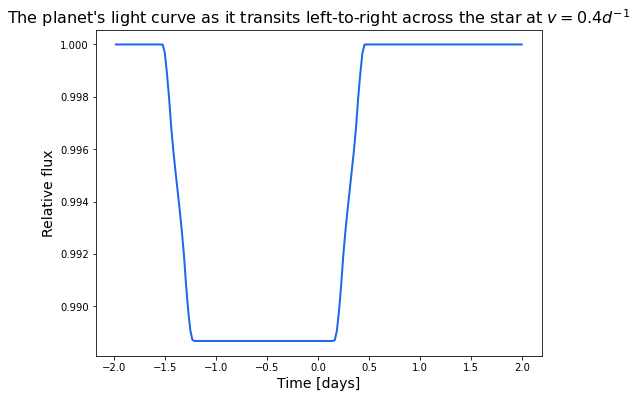

In [48]:
planetLC, overlapTimes = planet.gen_LC(t_arr = cutTimes)##Generate Light Curve

#overlapTimes, planetLC = cutLightCurve(overlapTimes, planetLC, -1.85,2.15)##Cutting and extending the periodic behavior of this light curve
#planetLC, overlapTimes = duplicateLightCurve(planetLC, overlapTimes, cutTimes[0],cutTimes[-1] - 1.05*(cutTimes[1]-cutTimes[0]))


fig, ax = plt.subplots(1,1,figsize=(8,6))##Plotting
ax.plot(overlapTimes,planetLC,color="#1969ea",ls="-",lw=2)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The planet's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

Filename: smallDonut


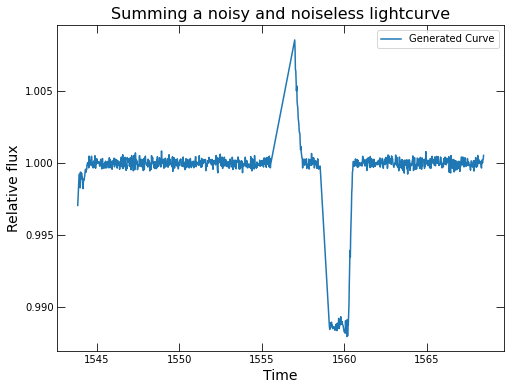

In [49]:
longTransitLC, overlapTimes = ebtExtendLC(planetLC, overlapTimes, cutTimes)
sumLC = ebtSumLightCurves(normLc, longTransitLC)##Summing and normalizing lightcurves
medLC = np.median(sumLC)
sumLC = sumLC/medLC
overlapTimes = overlapTimes + midTime

sumLC, overlapTimes = cleanTimes(sumLC, overlapTimes, times)

#overlapTimes = np.delete(overlapTimes, -1)

fig, ax = plt.subplots(1,1,figsize=(8,6))##PLotting
ax.plot(overlapTimes,sumLC,label = "Generated Curve", ls = '-')
ax.legend()
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"Summing a noisy and noiseless lightcurve",fontsize=16)

ax.tick_params(direction = "in", which = "major", length = 8, top = True, right = True)
ax.tick_params(direction = "in", which = "minor", length = 4, top = True, right = True)

filename = input("Filename:") ##Prompt to not forget to change the file name and overwrite existing outputs

plt.savefig("./output/"+filename)
plt.show()